In [94]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# read in the data
dataset = pd.read_csv('prepared_gasoline.csv')

# read in the geo data
geo = pd.read_csv('latlongeo.csv')
geo.drop(['Unnamed: 0', 'region'], axis=1, inplace=True)

# join them -- inner drops the lat/lon nan values
dataset = dataset.merge(geo, how='inner', on=['latitude', 'longitude'])

# add global mean of gas price for each observation
global_mean = dataset.groupby('date')['e5gas'].mean()
global_df = global_mean.to_frame()
global_df.rename(columns={"e5gas": "global_mean"}, inplace=True)
dataset = dataset.merge(global_df, right_index=True, left_on='date')

# add regional mean of gas price for each observation
state_mean = dataset.groupby(['date', 'state'])['e5gas'].mean()
state_df = state_mean.to_frame()
state_df.rename(columns={"e5gas": "state_mean"}, inplace=True)
dataset = dataset.merge(state_df, right_index=True, left_on=['date', 'state'])

# one hot encode state and marke
dataset['state'] = pd.Categorical(dataset['state']).codes

In [95]:
# run individual time series on station 1 and 2
# combine them into one values and run it again, predicting separately for 1 and 2 and compare
station_indices = dataset['station'].value_counts() == 575
full_series = pd.DataFrame()
full_series['T/F'] = station_indices[station_indices]
full_series['index'] = full_series.index
dataset_fullseries = dataset[dataset['station'].isin(full_series['index'])]

In [96]:
#station12 = dataset[(dataset['station'] == 1) | (dataset['station'] == 2)]
#df = station12
df = dataset_fullseries

In [97]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
df.set_index('date', inplace=True)
df.sort_index(inplace=True)
df['e5gas'].fillna(0, inplace=True)
cols = list(df)
cols.insert(0, cols.pop(cols.index('e5gas')))
df = df.loc[:, cols]

# let's include a variable that is a number of days since the beginning of the sample and then order by that variable
# you can drop it again after reordering -- or see if it helps

df.head()

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,e5gas,weekday,latitude,longitude,dautobahn,autobahn,aral,esso,jet,shell,total,rotterdam,brent,wti,eurusd,vehicles,state,station,global_mean,state_mean
date,,,,,,,,,,,,,,,,,,,,
2014-05-16,1.573706,5,52.317699,9.96611,5539.611816,0,0,0,0,0,0,0.622837,109.424042,101.258553,1.369886,6873.0,13,14565,1.546131,1.530105
2014-05-16,1.550250,5,51.089699,6.58208,1211.936890,0,0,0,0,0,0,0.622837,109.424042,101.258553,1.369886,7828.0,15,6071,1.546131,1.541350
2014-05-16,1.546222,5,51.675098,7.78013,6230.800781,0,0,0,0,0,0,0.622837,109.424042,101.258553,1.369886,7887.0,15,8793,1.546131,1.541350
2014-05-16,1.520765,5,51.194801,6.50602,3022.041504,0,0,0,0,0,0,0.622837,109.424042,101.258553,1.369886,12115.0,15,5991,1.546131,1.541350
2014-05-16,1.533444,5,51.557400,7.68249,1240.194946,0,0,0,0,0,0,0.622837,109.424042,101.258553,1.369886,31437.0,15,8595,1.546131,1.541350


In [98]:
df['date'] = df.index
df.sort_values(by=['station', 'date'], inplace=True)
df.drop('date', axis=1, inplace=True)
df.head()

,e5gas,weekday,latitude,longitude,dautobahn,autobahn,aral,esso,jet,shell,total,rotterdam,brent,wti,eurusd,vehicles,state,station,global_mean,state_mean
date,,,,,,,,,,,,,,,,,,,,
2014-05-16,1.536647,5,51.157501,10.0002,14850.392578,0,0,0,0,0,0,0.622837,109.424042,101.258553,1.369886,15211.0,10,0,1.546131,1.561237
2014-05-17,1.564000,6,51.157501,10.0002,14850.392578,0,0,0,0,0,0,0.622486,109.699997,101.669998,1.369580,9146.0,10,0,1.560708,1.578196
2014-05-18,1.569417,0,51.157501,10.0002,14850.392578,0,0,0,0,0,0,0.622136,109.699997,101.669998,1.369580,9843.0,10,0,1.564237,1.581731
2014-05-19,1.578167,1,51.157501,10.0002,14850.392578,0,0,0,0,0,0,0.621785,109.838928,102.008537,1.370161,13502.0,10,0,1.563935,1.581525
2014-05-20,1.599000,2,51.157501,10.0002,14850.392578,0,0,0,0,0,0,0.620475,109.522926,102.058907,1.368282,12876.0,10,0,1.566228,1.582620


In [99]:
values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]], axis=1, inplace=True)
reframed.head()

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.614797   0.833333   0.499847   0.451308   0.231638        0.0   
2   0.625740   1.000000   0.499847   0.451308   0.231638        0.0   
3   0.627907   0.000000   0.499847   0.451308   0.231638        0.0   
4   0.631408   0.166667   0.499847   0.451308   0.231638        0.0   
5   0.639743   0.333333   0.499847   0.451308   0.231638        0.0   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)    ...     var12(t-1)  \
1        0.0        0.0        0.0         0.0    ...       0.837361   
2        0.0        0.0        0.0         0.0    ...       0.836386   
3        0.0        0.0        0.0         0.0    ...       0.835411   
4        0.0        0.0        0.0         0.0    ...       0.834437   
5        0.0        0.0        0.0         0.0    ...       0.830794   

   var13(t-1)  var14(t-1)  var15(t-1)  var16(t-1)  var17(t-1)  var18(t-1)  \
1    0.930292    0.921895    0.999172    0.146931    0.384615  

In [103]:
reframed['var18(t-1)'].mean()

0.5026423335075378

In [85]:
# split into train and test sets
# need to do separately or maybe just order them?
n = 7316300
values = reframed.values
n_train_days = int(n*.8)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(5853040, 1, 20) (5853040,) (1463259, 1, 20) (1463259,)


Train on 5853040 samples, validate on 1463259 samples
Epoch 1/5
 - 36s - loss: 0.0279 - val_loss: 0.0255
Epoch 2/5
 - 33s - loss: 0.0142 - val_loss: 0.0215
Epoch 3/5
 - 34s - loss: 0.0124 - val_loss: 0.0176
Epoch 4/5
 - 34s - loss: 0.0107 - val_loss: 0.0110
Epoch 5/5
 - 33s - loss: 0.0088 - val_loss: 0.0084


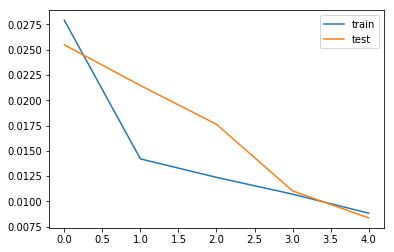

In [86]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=5, batch_size=7200, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [87]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.052
